In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import nltk
import operator
import os
import pandas as pd

%matplotlib inline

# ghostscript for plotting nltk trees
path_to_gs = r'C:\Program Files\gs\gs9.23\bin'
os.environ['PATH'] += os.pathsep + path_to_gs

# raw text of the book of genesis
genesis = nltk.corpus.genesis.raw()

In [2]:
#genesis = nltk.corpus.gutenberg.raw('melville-moby_dick.txt')
#genesis

# it's not quite this easy to read in a different book. need to do a lot of cleanup

In [3]:
#nltk.download() #corpora etc

In [4]:
def extract_entities(sent):
    
    tokens = nltk.word_tokenize(sent)
    pos_tokens = nltk.pos_tag(tokens)
    
    cp = nltk.RegexpParser('CHUNK: {<NNP>}')

    entities = []

    tree = cp.parse(pos_tokens)
    for subtree in tree.subtrees():
        if subtree.label() == 'CHUNK': 
            entities.append(list(subtree)[0][0])

    return entities

In [5]:
def word_in_target_list(source, target_list):
    if source in target_list:
        return True
    else:
        return False

In [6]:
def drop_unwanted_words(row, dropwords):

    for word in row:
        if word in dropwords:
            row.remove(word)

    return row

In [7]:
def get_entity_list():

    entity_list = []
    entities = []
    
    sents = nltk.sent_tokenize(genesis)
    genesis_sents = sents[:3698]

    for sent in genesis_sents:
        entities.append(extract_entities(sent))

    for row in entities:

        # drop unwanted words
        drop_unwanted_words(row, dropwords)

        # if there's data left in the row
        if len(row) > 1: 

            # drop self-references
            s = row[0]
            t = row[1:]

            if word_in_target_list(s, t):
                t = t.remove(s)

            # if there's data left in the row
            if t == None or len(t) == 1:
                continue
            else:
                t = list(set(t))
                entity_list.append((s, t))

    return entity_list

In [8]:
def build_adj_lines(entity_list):
    
    lines = []

    for row in entity_list:
        s = row[0]
        target_list = row[1]

        target_list = [s] + target_list
        line =' '.join(target_list)
        
        lines.append(line)
    
    return lines

In [9]:
dropwords = ['Day', 'Night', 'Ye', 'Where', 'Thorns', 'Thou', 'O', 'Put', 'Unto', 'My', 'G', "God's", 'Fear', 'Abr', 'Wherefore',
            'Behold', 'Shall', 'Up', 'Hear', '╜', '<', '>', 'à', 'Go', 'A', 'E', 'à', 'é', 'än', 'äta', 'B', '/h3', 'zu']

In [10]:
entity_list = get_entity_list()
entity_list[:10]

[('LORD', ['Eden', 'God']),
 ('LORD', ['Eden', 'God']),
 ('LORD', ['Adam', 'God']),
 ('Adam', ['Man', 'Woman']),
 ('LORD', ['Adam', 'God']),
 ('Adam', ['LORD', 'God']),
 ('Adam', ['Eve', 'Cain', 'LORD']),
 ('LORD', ['Cain', 'Abel']),
 ('Cain', ['Abel']),
 ('LORD', ['Abel', 'Cain'])]

In [11]:
lines = build_adj_lines(entity_list)
lines[:10]

['LORD Eden God',
 'LORD Eden God',
 'LORD Adam God',
 'Adam Man Woman',
 'LORD Adam God',
 'Adam LORD God',
 'Adam Eve Cain LORD',
 'LORD Cain Abel',
 'Cain Abel',
 'LORD Abel Cain']

In [12]:
# write the file for reading into gephi
path = r'C:\Users\groov\PythonCode\GraphData'
file = 'genesis.adjlist.csv'

path = path + '\\' + file

f = open(path,"w+")

for line in lines:
    line += '\n'
    f.write(line)
    
f.close()

In [13]:
path = r'C:\Users\groov\PythonCode\GraphData'
file = 'genesis.adjlist.csv'

path = path + '\\' + file

G = nx.read_adjlist(path)
G = nx.DiGraph(G)

# these edges didn't come through due to relationship being in two separate sentences
G.add_edge('Nahor', 'Reumah')
G.add_edge('Reumah', 'Nahor')

# remove junk
remove = ['LO', 'Provide', 'Will', 'Everlasting', 'Who', 'South', 'Quickly', 'May', 'Make', 'Am', 'Be', 'Behold', 'Bow', 'Come', 'Do', 'Forasmuch', 'Again', 'Almighty', 'Get', 'Give', 'Happy', 'How', 'Know',
         'Lo', 'Me', 'Most', 'Oh', 'Please', 'Say', 'See', 'Send', 'Take', 'Therefore', 'journeyed', 'mount', 'unto', 'ye', 'eat',
         'Thus', 'Thy', 'Moriah', 'Let', 'Isra', 'Ai', 'Hurry', 'Bring', 'Which', 'Gather', 'Mighty', 'Returned', 'Peace', 'Arise',
         'Earth', 'Peradventure', 'Return']
G.remove_nodes_from(remove)

# fix things
mapping={'Abram\'s':'Abram', 'Dinah\'s':'Dinah', 'God\'s':'God', 'Israel\'s':'Israel', 'Jacob\'s':'Jacob', 'Lotan\'s':'Lotan',
        'LORD':'God', 'Yahweh':'God', 'Woman':'Eve'}
G = nx.relabel_nodes(G, mapping)

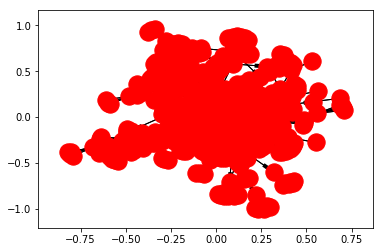

In [14]:
nx.draw_networkx(G, with_labels=False)

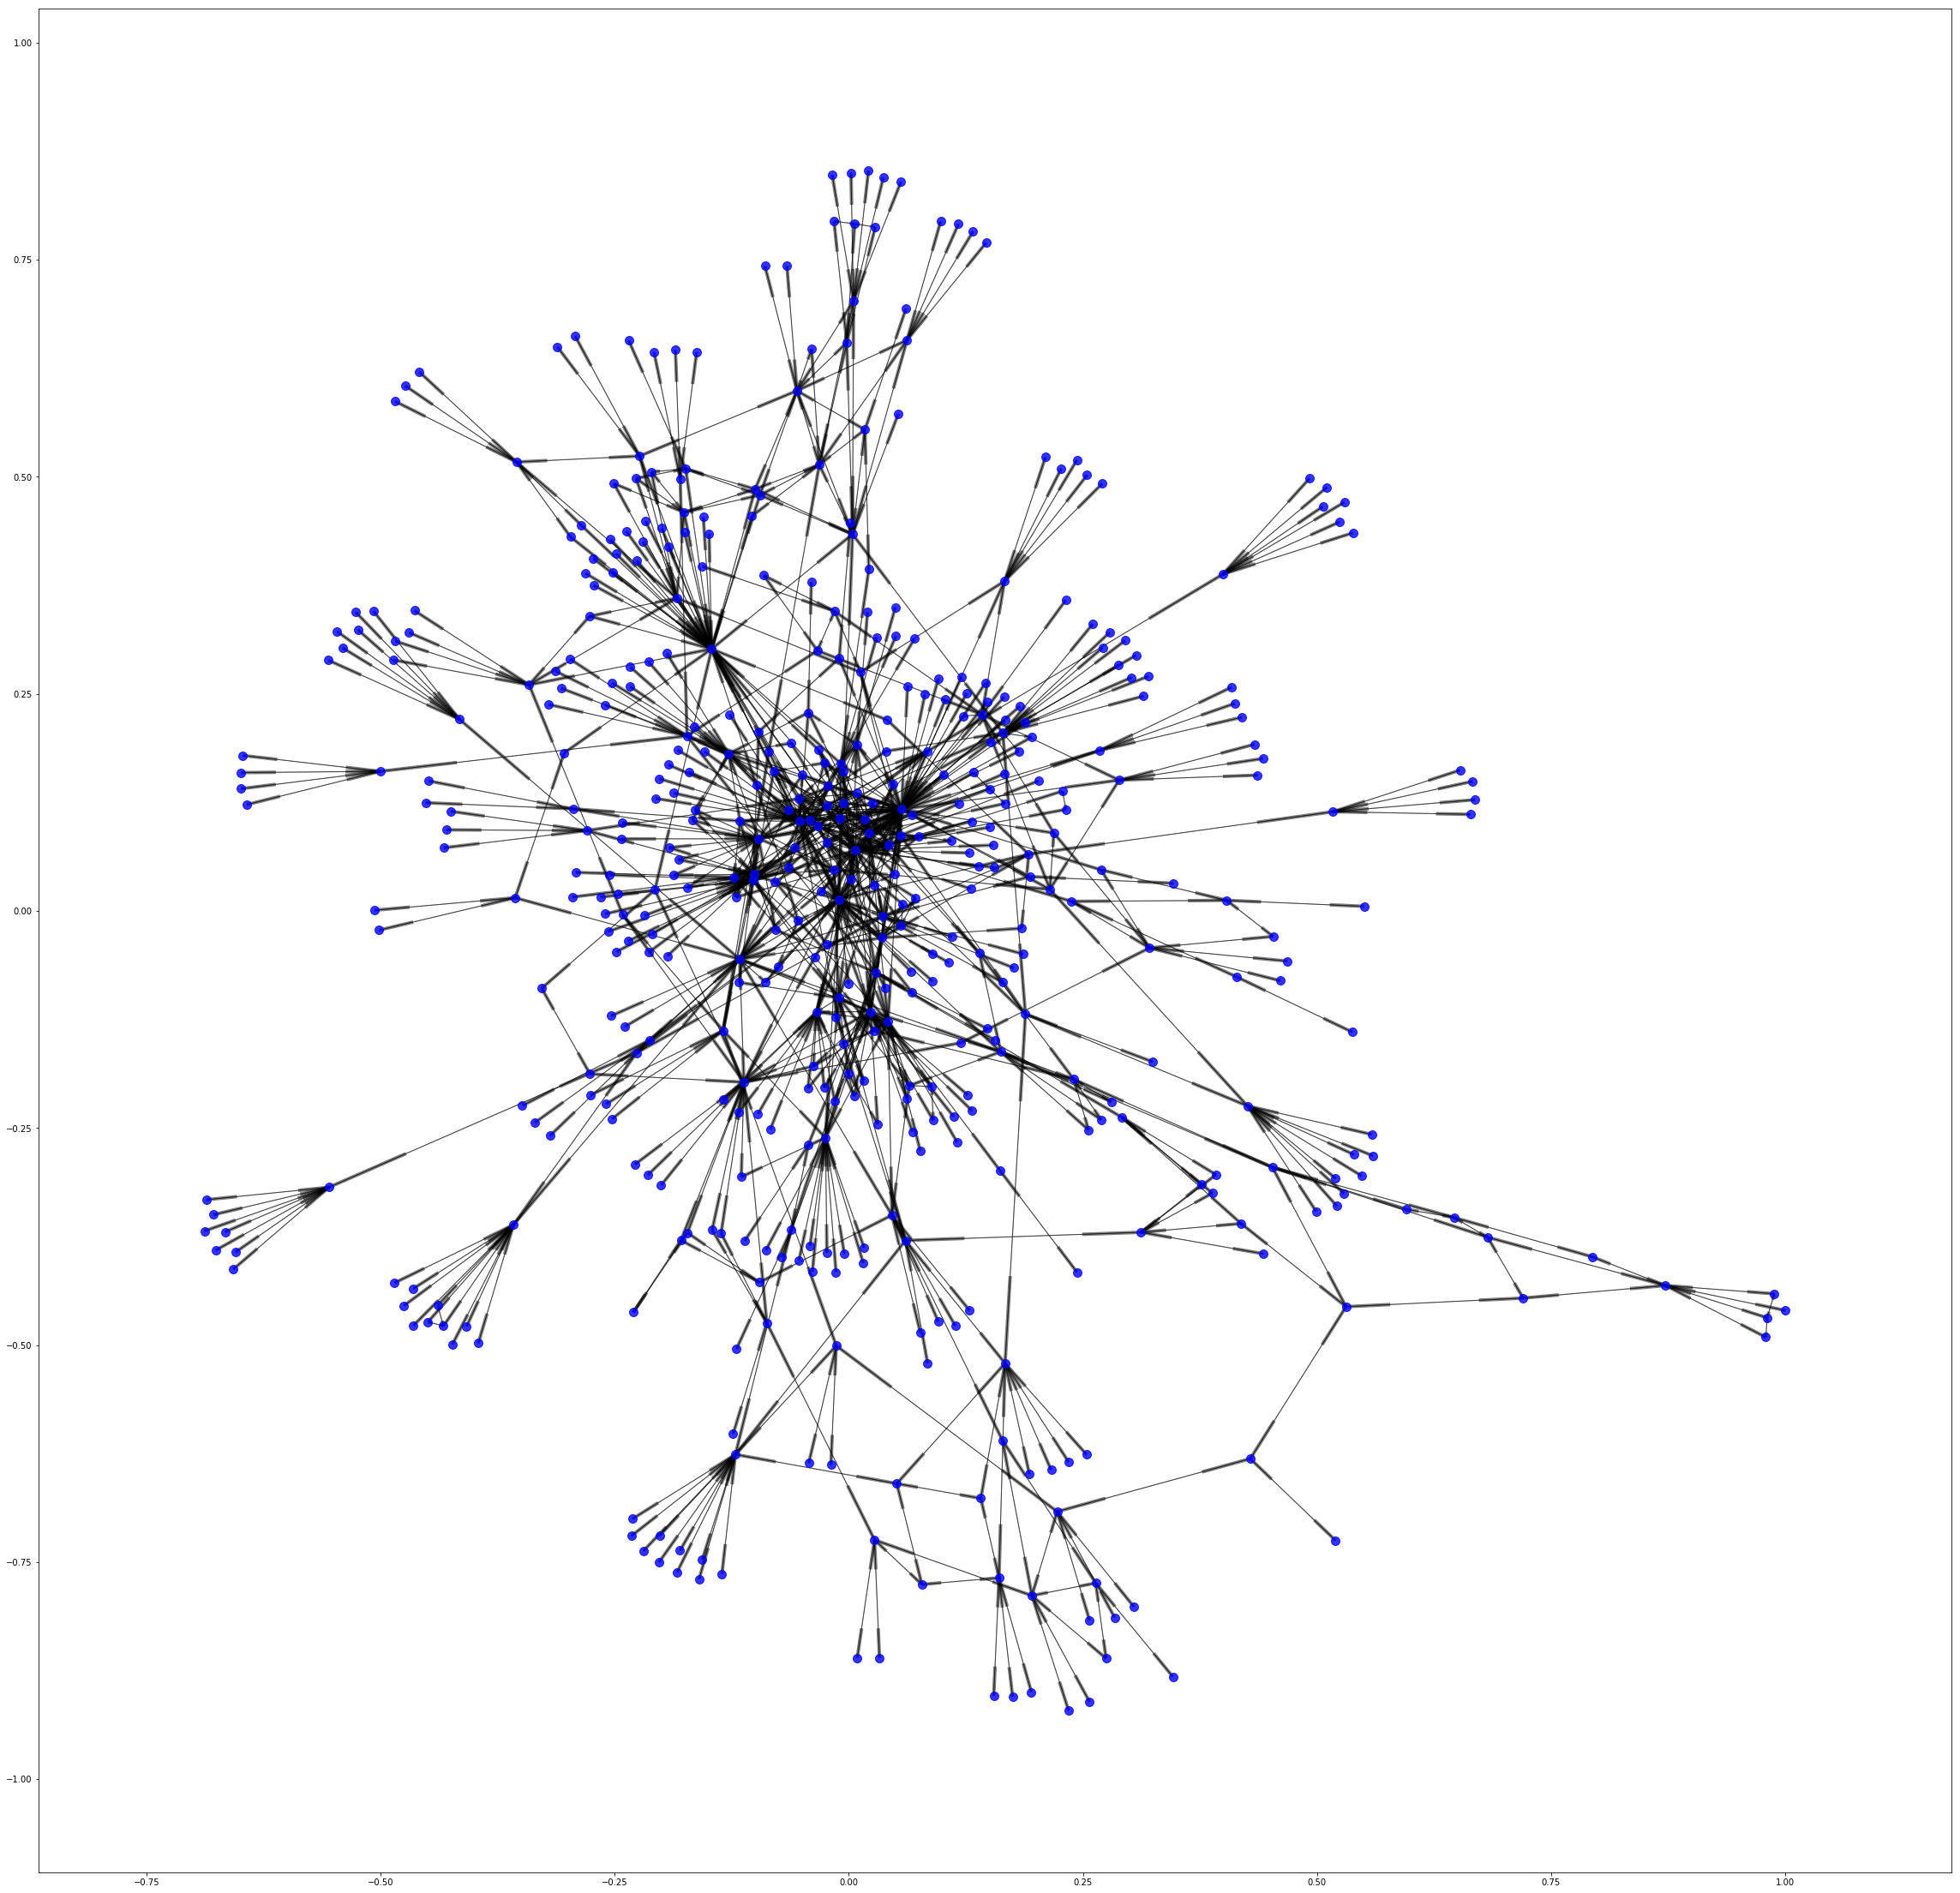

In [15]:
plt.figure(3, figsize=(40,40))

pos=nx.spring_layout(G) # positions for all nodes
nx.draw_networkx_nodes(G, pos, node_color='blue', node_size=100, alpha=0.8)
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)

plt.show()

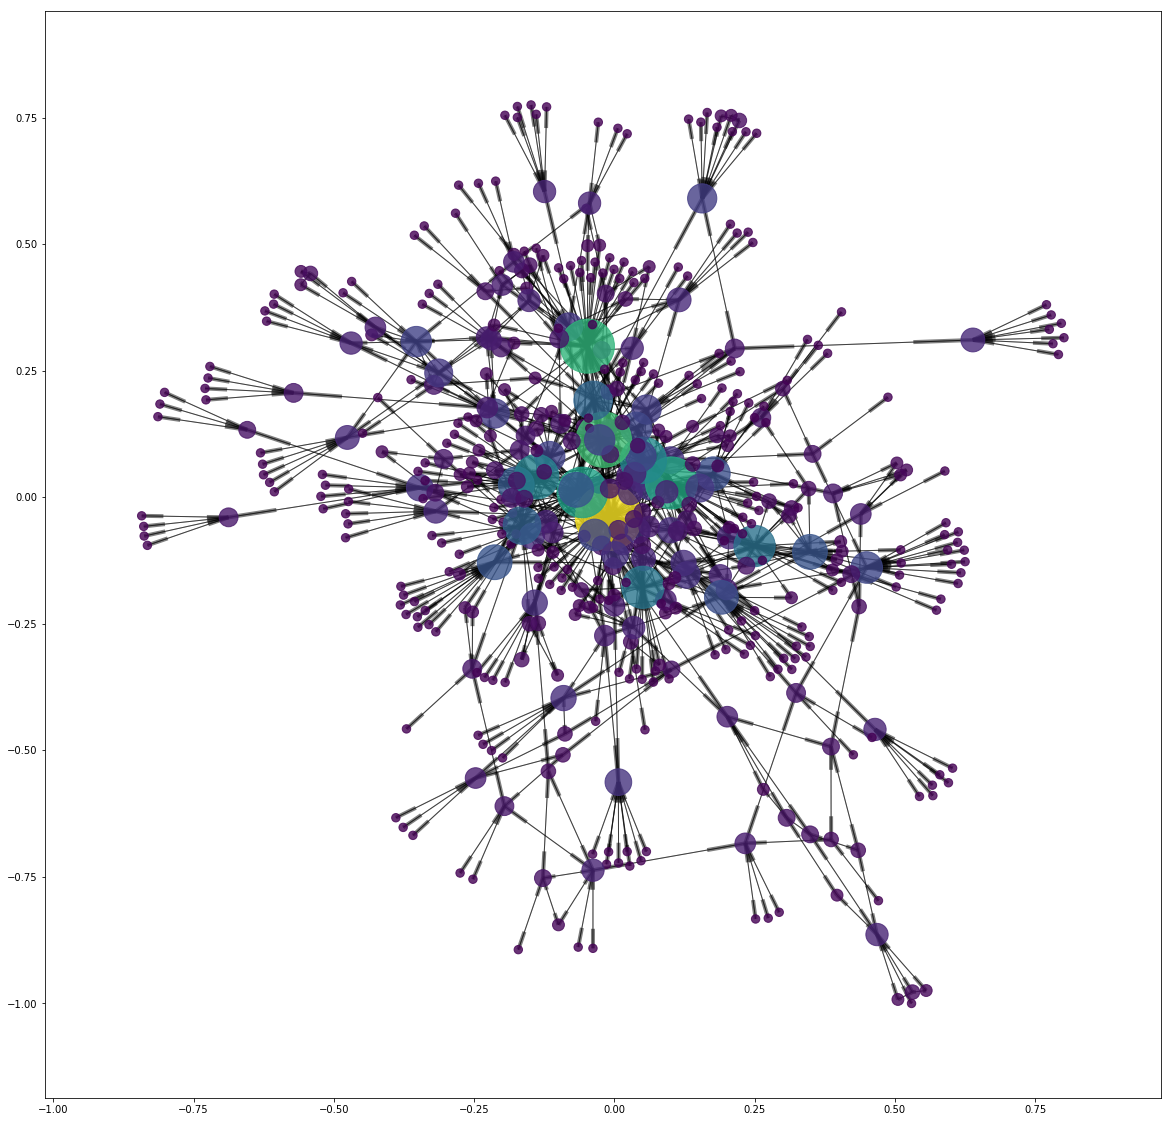

In [16]:
# improved graph with nodesize based on degrees. adding labels makes this unreadable
# next: add labels to nodes that have > n degrees.

node_color = [G.degree(v) for v in G]

node_size = []

degCent = nx.out_degree_centrality(G)
for item in degCent.items():
    node_size.append(int(item[1]*35000))

plt.figure(1, figsize=(20,20))

pos=nx.spring_layout(G) # positions for all nodes
nx.draw_networkx_nodes(G, pos, node_color=node_color, node_size=node_size, alpha=0.8)
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
#nx.draw_networkx_labels(G, pos, font_size=10, font_color='red') # too messy, need to only add it for the main ones

plt.show()

In [17]:
def plot_chart(data):
    
    df = pd.DataFrame(data)
    df.columns = ['name', 'value']
    df.set_index('name', inplace=True)
    df.plot.barh(figsize=(6, 8))
    plt.gca().invert_yaxis()

In [18]:
def top_pagerank():
        
    pr = nx.pagerank(G, alpha=0.85)
    results = sorted(pr.items(), key=operator.itemgetter(1), reverse=True)[0:20]

    nodes = []

    for node in results:
        nodes.append(node)

    return nodes

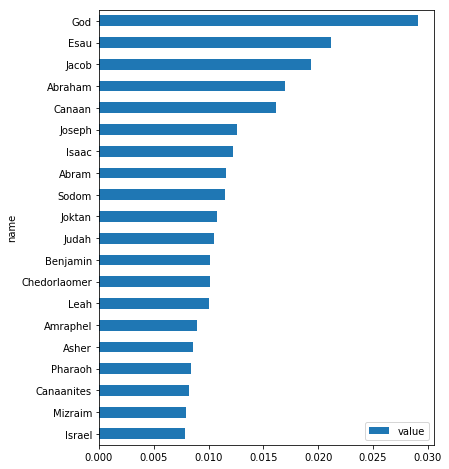

In [19]:
data = top_pagerank()
plot_chart(data)

In [20]:
def top_degree():
        
    degCent = nx.degree_centrality(G)
    node = sorted(degCent.items(), key=operator.itemgetter(1), reverse=True)[0:20]
    return node

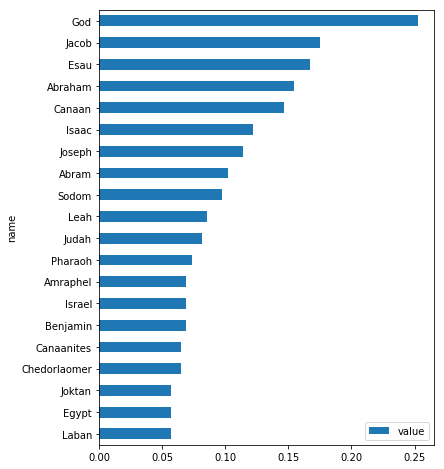

In [21]:
data = top_degree()
plot_chart(data)

In [39]:
def top_closeness():
        
    closeCent = nx.closeness_centrality(G)
    node = sorted(closeCent.items(), key=operator.itemgetter(1), reverse=True)[0:20]
    node = sorted(closeCent.items(), key=operator.itemgetter(1), reverse=True)[-20:]
    return node

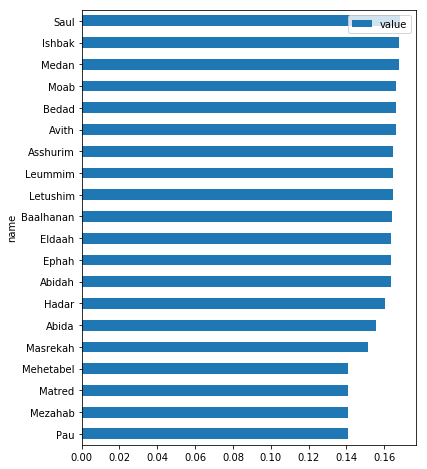

In [40]:
data = top_closeness()
plot_chart(data)

In [33]:
def top_betweenness():
        
    btwnCent = nx.betweenness_centrality(G, normalized=True)
    node = sorted(btwnCent.items(), key=operator.itemgetter(1), reverse=True)[0:20]
    return node

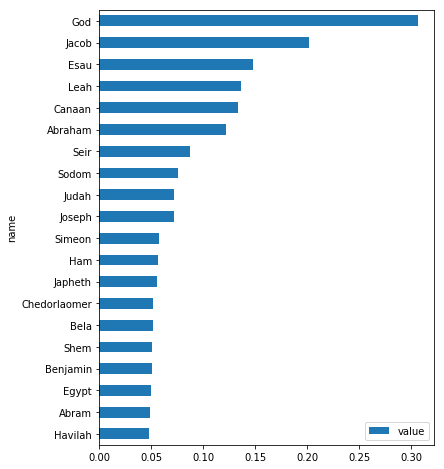

In [34]:
data = top_betweenness()
plot_chart(data)

In [26]:
G.number_of_nodes(), G.number_of_edges(), G.number_of_selfloops()

(492, 1713, 3)

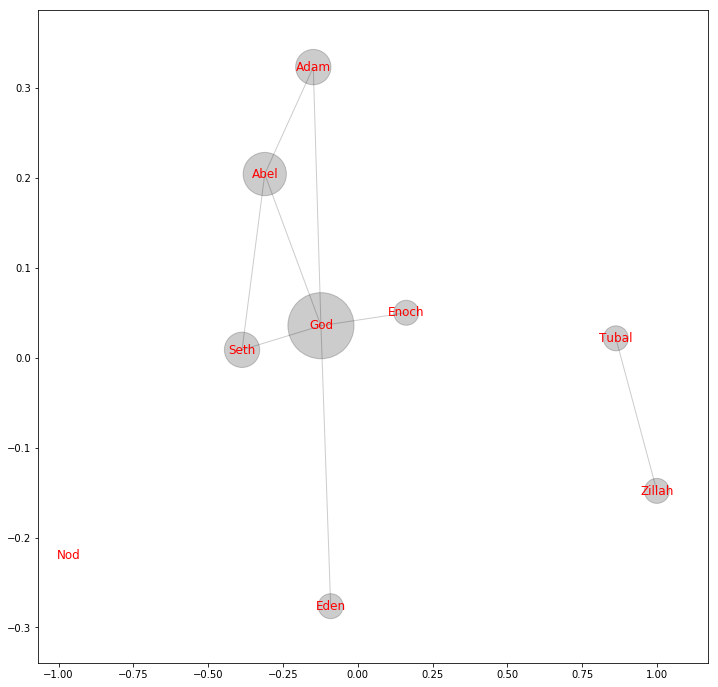

In [50]:
# egocentric graph
F = G.copy()

ego = 'Cain'
egograph = nx.ego_graph(F, ego)
egograph = egograph.to_undirected()

egograph.remove_node(ego)

#isolates = nx.isolates(egograph)
#egograph.remove_nodes_from(isolates)

#node_color = [G.degree(v) for v in egograph]

node_size = []

degCent = nx.degree_centrality(egograph)
for item in degCent.items():
    node_size.append(int(item[1]*5000))

plt.figure(1, figsize=(12,12))

pos=nx.spring_layout(egograph, k=0.3,iterations=20) # positions for all nodes
nx.draw_networkx_nodes(egograph, pos, node_color='black', node_size=node_size, alpha=0.2)
nx.draw_networkx_edges(egograph, pos, width=1.0, alpha=0.2)
nx.draw_networkx_labels(egograph, pos, font_size=12, font_color='red')

plt.show()

In [28]:
from networkx.algorithms import community

def print_cliques():

    F = G.copy()
    F = F.to_undirected()

    ego = 'Er'
    egograph = nx.ego_graph(F, ego)
    egograph = egograph.to_undirected()

    for i in range(2,8):

        print('k-val: {}\n'.format(i))

        for j in list(nx.community.k_clique_communities(F, k=i)):
            print('{}\n'.format(list(j)))

        i+=1

In [29]:
#print_cliques()

In [30]:
#sorted(G.degree, key=lambda x: x[1], reverse=False)